## November 2021 Kaggle Tabular Playground Series

Performance metric --> AUC

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import plot_roc_curve, classification_report, auc
from sklearn.preprocessing import MinMaxScaler

sns.set()

In [28]:
# Preliminary analysis
dfall = pd.read_csv("dataML/trainNOV21.csv").drop("id", axis=1)  # change path if needed (dataset link: https://www.kaggle.com/c/tabular-playground-series-nov-2021/data)
print(dfall.shape)
print(dfall.dtypes.unique())
print(dfall.isnull().sum().any())
(dfall["target"].value_counts())/(len(dfall))   # balanced dataset
# Visualization on another notebook using pandas_profiling, too many features to do it here

(600000, 101)
[dtype('float64') dtype('int64')]
False


1    0.50601
0    0.49399
Name: target, dtype: float64

In [30]:
# !! Use only 15% of the dataset as an example, otherwise computations are too slow
df = dfall.sample(frac=0.15, random_state=123)
print(df.shape)
(df["target"].value_counts())/(len(df)) 

(90000, 101)


1    0.505444
0    0.494556
Name: target, dtype: float64

### Define splits and scale the data

In [31]:
# define X and y data
X = df.drop("target", axis=1)
y = df["target"]
# Split in train and final evaluation set
X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, random_state=10, shuffle=True)
# Scale
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
X_final_test = pd.DataFrame(scaler.transform(X_final_test), columns=X_final_test.columns)

### Features Selection

In [32]:
###### 1) Analyze correlation
correl_mat = X_train.corr()
# do not plot, too big
# all features have very low correlation with eachother, 
# no clear indication on which features to drop here

In [33]:
###### 2) Univariate features selection
from sklearn.feature_selection import SelectKBest, SelectFdr, SelectFpr, SelectFwe, chi2, f_classif
from functools import reduce

univariate_fs_methods = [SelectKBest(chi2, k=50), SelectKBest(f_classif, k=50), 
                        SelectFdr(chi2, alpha=0.05), SelectFpr(chi2, alpha=0.05), SelectFwe(chi2, alpha=0.05)]
names = ["KBest_chi2", "KBest_fclass", "FDR", "FPR", "FWE"]

# loop over all the methods
results = []
for name, method in zip(names, univariate_fs_methods):
    selection_method = method.fit(X_train, y_train)
    selected = list(X_train.columns[selection_method.get_support()])  # select column names given True/False indexes list obtained from .get_support()
    results.append(selected)
    print(f"{len(selected)} Features selected by {name}: {selected}")

selected_by_all = reduce(np.intersect1d, results) # list(set.intersection(*[set(x) for x in results])) # apply intersect1d to (a list of) multiple lists
reduce(np.intersect1d, results)
print("-"*100)
print(f"{len(selected_by_all)} Features selected by all the univariate methods: {selected_by_all}")

# keep all the features selected by all the univariate methods

50 Features selected by KBest_chi2: ['f1', 'f2', 'f3', 'f5', 'f8', 'f10', 'f11', 'f14', 'f15', 'f17', 'f18', 'f21', 'f22', 'f24', 'f25', 'f26', 'f27', 'f30', 'f32', 'f34', 'f37', 'f40', 'f41', 'f43', 'f45', 'f47', 'f49', 'f50', 'f53', 'f54', 'f55', 'f57', 'f60', 'f66', 'f67', 'f70', 'f71', 'f74', 'f77', 'f80', 'f81', 'f82', 'f85', 'f86', 'f91', 'f94', 'f95', 'f96', 'f97', 'f98']
50 Features selected by KBest_fclass: ['f1', 'f2', 'f3', 'f4', 'f8', 'f9', 'f10', 'f17', 'f20', 'f21', 'f22', 'f24', 'f25', 'f26', 'f27', 'f30', 'f31', 'f32', 'f33', 'f34', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f47', 'f48', 'f49', 'f50', 'f51', 'f53', 'f54', 'f55', 'f57', 'f60', 'f62', 'f64', 'f66', 'f71', 'f80', 'f81', 'f82', 'f83', 'f91', 'f94', 'f95', 'f96', 'f97', 'f98']
23 Features selected by FDR: ['f3', 'f8', 'f10', 'f17', 'f22', 'f25', 'f26', 'f34', 'f40', 'f41', 'f43', 'f47', 'f50', 'f54', 'f55', 'f57', 'f66', 'f71', 'f80', 'f82', 'f91', 'f96', 'f97']
25 Features selected by FPR: ['f3', 'f8', 'f10

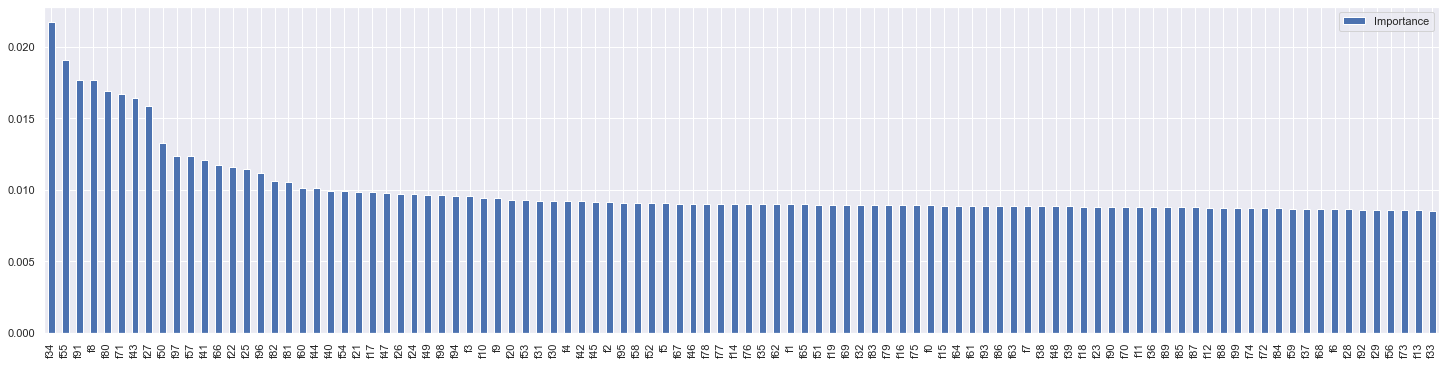

In [34]:
###### 3) Tree-based features selection
rf = RandomForestClassifier().fit(X_train, y_train)

feat_imp_df = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
feat_imp_df.plot(kind='bar', figsize=(25,6));

In [35]:
selectedTree = feat_imp_df[feat_imp_df["Importance"] > 0.010]
selectedTree = list(selectedTree.index)
print(f"{len(selectedTree)} features with importance score > 0.010 selected by Tree-based method: {selectedTree}")

20 features with importance score > 0.010 selected by Tree-based method: ['f34', 'f55', 'f91', 'f8', 'f80', 'f71', 'f43', 'f27', 'f50', 'f97', 'f57', 'f41', 'f66', 'f22', 'f25', 'f96', 'f82', 'f81', 'f60', 'f44']


In [37]:
###### 4) Recursive features elimination (RFE)
from sklearn.feature_selection import RFE

# just as an example, too slow
# rfe = RFE(rf, n_features_to_select=35).fit(X_train, y_train)
# selected_RFE = list(X_train.columns[rfe.get_support()]) 
# print(f"{len(selected_RFE)} Features selected by RFE method: {selected_RFE}")

In [38]:
# Define features to drop
all_features_selected = list(selected_by_all) + selectedTree #+ selected_RFE
feat_to_keep = list(set(all_features_selected))   # eliminate duplicate features, set has no duplicates

print(f"{len(feat_to_keep)} Features selected: {feat_to_keep}")

21 Features selected: ['f81', 'f60', 'f27', 'f41', 'f25', 'f71', 'f40', 'f57', 'f43', 'f8', 'f50', 'f34', 'f55', 'f80', 'f44', 'f96', 'f22', 'f97', 'f82', 'f66', 'f91']


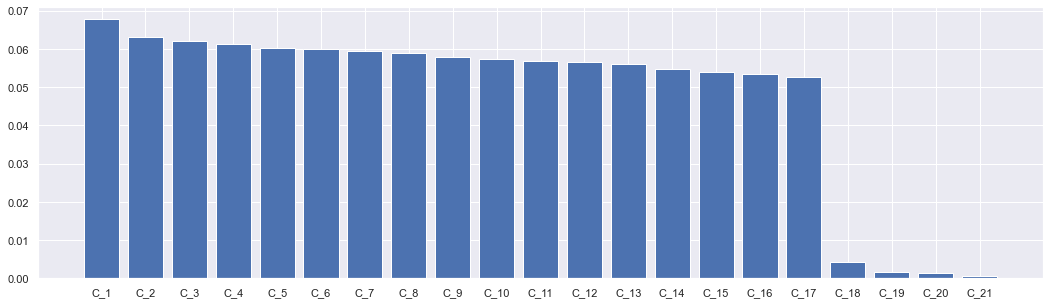

In [39]:
###### 5) PCA on selected features
from sklearn.decomposition import PCA

X_train_fs = X_train[list(feat_to_keep)]

pca = PCA().fit(X_train_fs)

plt.figure(figsize=(18,5))
plt.bar([f"C_{i+1}" for i in range(0, len(feat_to_keep))], pca.explained_variance_ratio_);

# it could be a good option to drop the last 4 principal components

In [42]:
# Drop the last 3 Principal components
pca2 = PCA(n_components=17)
X_train_pca = pd.DataFrame(pca2.fit_transform(X_train_fs), columns=[f"C_{i+1}" for i in range(0, 17)])
print(f"Explained variance from first 17 Principal Components: {sum(pca2.explained_variance_ratio_)}")
X_final_test_pca = pd.DataFrame(pca2.transform(X_final_test[list(feat_to_keep)]), columns=[f"C_{i+1}" for i in range(0, 17)])

X_train_pca.head(3)

Explained variance from first 17 Principal Components: 0.9921403342768522


,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9,C_10,C_11,C_12,C_13,C_14,C_15,C_16,C_17
0,0.099730,0.136110,-0.018556,0.208990,0.312663,0.267166,0.110164,-0.207783,-0.024021,0.211596,-0.303846,-0.021897,-0.142889,0.139794,0.042949,-0.393919,0.189303
1,0.519657,0.110189,-0.035904,-0.017302,0.204378,-0.044963,-0.182339,-0.270452,0.105120,-0.165094,0.058998,-0.030199,0.041474,-0.003252,0.170862,-0.021255,0.302884
2,-0.284677,-0.090475,0.220307,-0.499729,0.010151,-0.083517,0.280703,-0.256395,0.154083,-0.295314,0.111428,-0.185483,0.290365,0.214002,0.283573,0.038344,-0.238936


### Model selection with nested CV

**!! Only two models and few hyperparameters tested, because there are too many datapoints and the training is too slow**

In [45]:
# Using the functions defined in the file AG_nested_CrossVal.py
from AG_nested_CrossVal import inner_CV_setup, nestedCV_model_selection, final_tuning

list_models = [RandomForestClassifier(), LinearDiscriminantAnalysis()]  
# KNeighborsClassifier(), BaggingClassifier(), LogisticRegression(), SVC(kernel="rbf")

param_grids = [{"n_estimators": [100], "max_depth": [50, None]}, {"shrinkage": [None]}]  # "criterion": ["gini", "entropy"]
# {"n_neighbors": [10, 50, 100], "weights": ['uniform', 'distance']}, {"n_estimators": [30, 50, 100, 150], "max_features": [0.5, 0.75, 1.0]}, {"C": [0.1, 0.5, 1, 2, 5]}, {"C": [0.1, 0.5, 1, 2, 5], "gamma": ["scale", "auto"]}

mod_names = ("RandomForest", "LDA") # "kNN", "BaggingTrees", "LogReg", "SVC"

# prepare the inner cv (stratifiedKfold and GridSearchCV for inner CV)
dict_CVgrids = inner_CV_setup(list_models, param_grids, mod_names, 3, scoring_metric="roc_auc", seed=33)

# perform nested CV (stratifiedKfold for outer CV)
nestedCV_results = nestedCV_model_selection(dict_CVgrids, 3, X_train_pca, y_train, scoring_metric="roc_auc", seed=22)
nestedCV_results

,LDA,RandomForest
OuterCV_average_Score%,71.180798,69.605887
OuterCV_std%,0.494157,0.413679


### Final evaluation for the best model & training for production

In [46]:
# Identify best model
best_model = LinearDiscriminantAnalysis()
best_grid = {"shrinkage": [None]}

# final hyperparams tuning
best_mod_tuned = final_tuning(best_model, best_grid, 4, X_train_pca, y_train, scoring_metric="roc_auc", seed=11)  # stratifiedKfold and GridSearchCV
print(f"Best model with tuned hyperparameters: {best_mod_tuned}")

Best model with tuned hyperparameters: LinearDiscriminantAnalysis()


In [47]:
# Final evaluation for best tuned models
best_mod_tuned.fit(X_train_pca, y_train)
predictions = best_mod_tuned.predict(X_final_test_pca)
print(classification_report(y_final_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66     11220
           1       0.66      0.68      0.67     11280

    accuracy                           0.67     22500
   macro avg       0.67      0.67      0.67     22500
weighted avg       0.67      0.67      0.67     22500



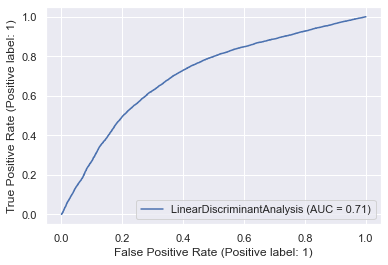

In [48]:
plot_roc_curve(best_mod_tuned, X_final_test_pca, y_final_test);

In [50]:
# Model for production
# All dataset with only selected features
X_all = X[list(feat_to_keep)]
# scale
X_all = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns) 
# apply pca (see pca2 above)
X_all_pca = pca2.fit_transform(X_all)
model_prod = best_mod_tuned.fit(X_all_pca, y)